In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use("ggplot")

# 目次
時系列データ
- データのダウンサンプリング

時系列解析の常識
- トレンド・季節性・残差
- 自己相関（ACF）・偏自己相関（PACF）
- 系列
    - 階差系列
    - 対数系列
    - 季節調整済み系列
- 定常過程・非定常過程
    - ホワイトノイズ 
    - 定常性はなぜ重要か
    - 非定常過程を定常過程に変換するには
    - 単位根過程
    - Augumented Dickey-Fuller test

統計モデル
- パラメータ
    - BIC基準の探索
    - ARMA(p, q)の次数の自動推定
    - AIC基準の探索
- SARIMAモデル
- 予測
- testデータを通して検証
- 予測誤差

## 参考
https://momonoki2017.blogspot.com/search/label/Python%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90　（7割方これ）

https://aidemy.net/courses/5060　Aidemy 時系列解析Ⅰ　（3割方これ）

https://www.procrasist.com/entry/12-time-series

## 時系列データ

https://momonoki2017.blogspot.com/2018/02/python4.html

In [5]:
import numpy as np
n = 365
date_index=pd.date_range('2018-01-01', freq='D', periods=365) # 日付1年分 
values = np.cumsum(np.random.randn(n)) # 正規乱数365個、足し合わせ
df = pd.DataFrame({'val': values}, index=date_index)
df.head()

,val
2018-01-01,-0.866185
2018-01-02,-1.608943
2018-01-03,-1.358374
2018-01-04,-0.087018
2018-01-05,0.576714


In [6]:
df.shape

(365, 1)

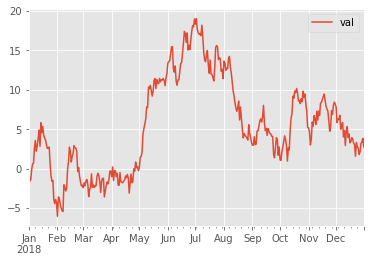

In [7]:
df.plot()

### データのダウンサンプリング
- ダウンサンプリング＝日時データを週単位、月単位に集約すること
- 月毎で集約、値に平均値(mean)を適用するときは、DataFrame変数名.resample('M').mean()とすれば、ダウンサンプリングができる

In [8]:
df_down = df.resample("M").mean()

In [9]:
df_down.head()

,val
2018-01-31,1.246323
2018-02-28,-1.088474
2018-03-31,-1.847327
2018-04-30,-1.002477
2018-05-31,8.679417


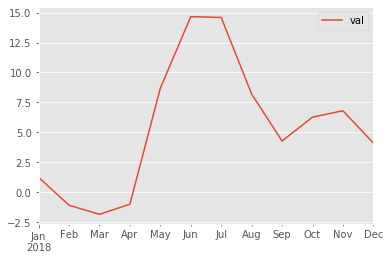

In [10]:
df_down.plot()

In [11]:
df_down = df_down.rename(columns={"val" : "val_month"})

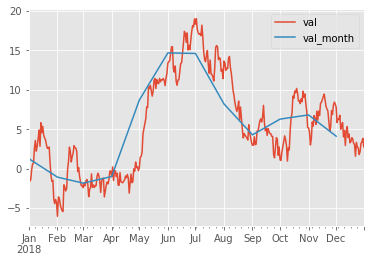

In [12]:
axis = df.plot() #日次
df_down.plot(ax = axis) #月次

## 時系列分析の常識
https://momonoki2017.blogspot.com/2018/03/python5.html

### データの準備
- 飛行機乗客数のデータ

In [13]:
import statsmodels.api as sm

In [14]:
sm.__version__

'0.10.1'

In [16]:
import pandas as pd
df = pd.read_csv("data/AirPassengers.csv")

In [17]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [18]:
df.shape

(144, 2)

In [19]:
passengers = pd.Series(df["#Passengers"], dtype="float")
passengers.index = pd.to_datetime(df["Month"])

In [20]:
passengers

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: #Passengers, Length: 144, dtype: float64

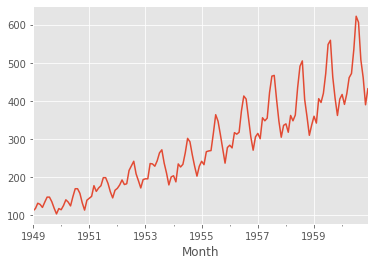

In [21]:
passengers.plot()

### トレンド・季節性・残差
- トレンド：データの長期的な傾向。正負がある
- 季節性：周期的に繰り返す変動　※四季と関係なく季節性という
- 残差：トレンドと季節性をオリジナルから除いたもの

In [23]:
res = sm.tsa.seasonal_decompose(passengers)

In [24]:
original = passengers #オリジナルデータ
trend = res.trend #トレンド
seasonal = res.seasonal #季節性
residual = res.resid #残差

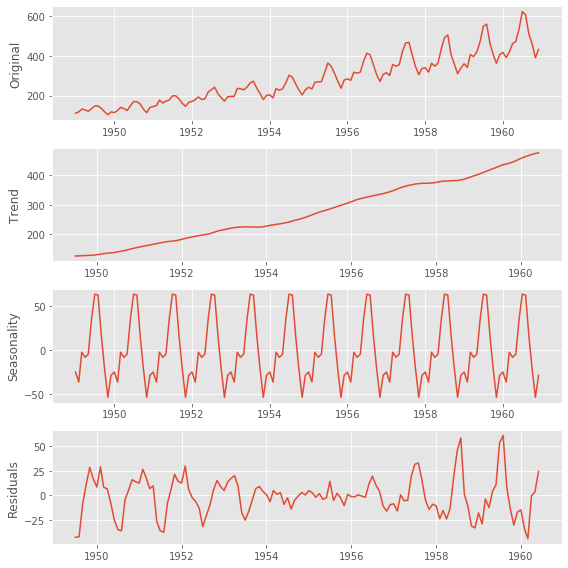

In [27]:

plt.figure(figsize=(8, 8))

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

Original = Trend + Seasonality + Residuals

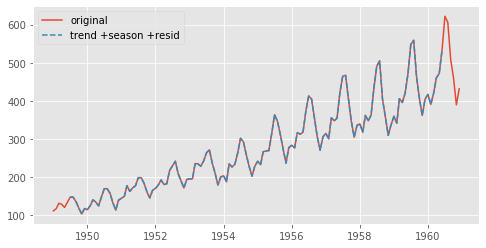

In [28]:
sum_three_data = trend + seasonal + residual # トレンド + 季節性 + 残差

plt.figure(figsize=(8, 4)) 
plt.plot(original, label='original')
plt.plot(sum_three_data, label='trend +season +resid', linestyle='--')
plt.legend(loc='best') 

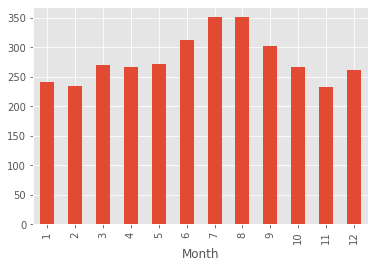

In [30]:
passengers_month_mean = passengers.groupby(passengers.index.month).mean()
passengers_month_mean.plot(kind='bar')

### 自己相関（ACF）

- 過去のデータが現在のデータにどれくらい影響しているか
- どれだけデータをずらすか＝lag

In [31]:
# 自己相関係数の出力
passengers_acf = sm.tsa.stattools.acf(passengers, nlags=40) #ラグ=40(デフォルト値)、省略可能
passengers_acf

C:\Users\daich\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

ライブラリ使わずに自前で計算すると以下のようになる。（結果は一致）

In [32]:
LAG = 40 # 計算ラグ数
rk = np.empty(LAG+1) # 自己相関係数の計算結果を保持用
y = np.array(passengers) # 乗客数データのndarray作成（計算用）
y_mean = np.mean(y) # 乗客数の平均値

# ラグ0の自己相関係数：1.0
rk[0] = np.sum((y - y_mean)**2) / np.sum((y - y_mean)**2) 

# ラグ1〜40の自己相関係数：-1.0〜1.0
for k in np.arange(1, LAG+1): 
    rk[k] = np.sum((y[k:] - y_mean)*(y[:-k] - y_mean)) / np.sum((y - y_mean)**2)

print(rk) # -> acf()結果と同じ

[1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376 0.48248203 0.51712699
 0.53218983 0.49397569 0.43772134 0.3876029  0.34802503 0.31498388
 0.28849682 0.27080187 0.26429011 0.27679934 0.2985215  0.32558712
 0.3370236  0.30333486 0.25397708 0.21065534 0.17217092]


自己相関係数の可視化　-> コレログラム

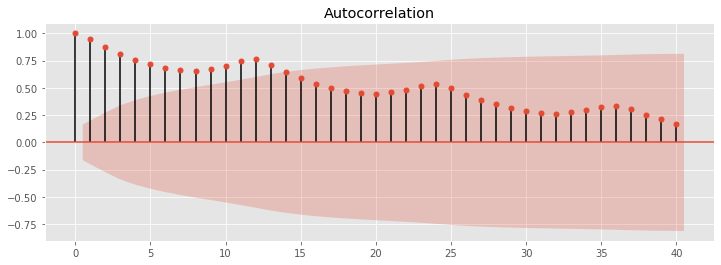

In [33]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(passengers, lags=40, ax=ax1) #飛行機乗客数データ、ラグ40、グラフaxes
plt.show()

- 薄い赤：95%信頼区間
- x軸はラグ、y軸は自己相関係数

自己相関がない場合は、どのような図になる？

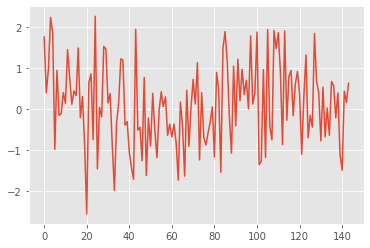

In [34]:
np.random.seed(0) # 乱数の種固定
random_data = np.random.normal(0, 1, 144) # 平均0、分散1、144個（乗客数データと同じ）のランダムデータ作成
plt.plot(random_data) 

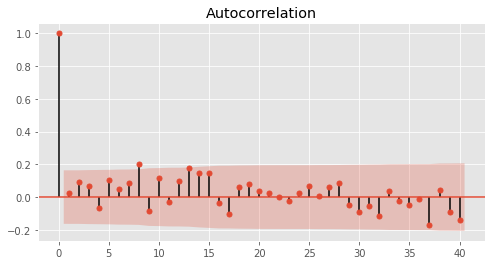

In [35]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(random_data, lags=40, ax=ax1) # ランダムデータを指定
plt.show()

### 偏自己相関（PACF）

- ある時点同士だけの関係性
- 今日と二日前の関係には間接的に一日前の影響が含まれる。偏自己相関を使うと、一日前の影響を除いて今日と二日前だけの関係を調べられる

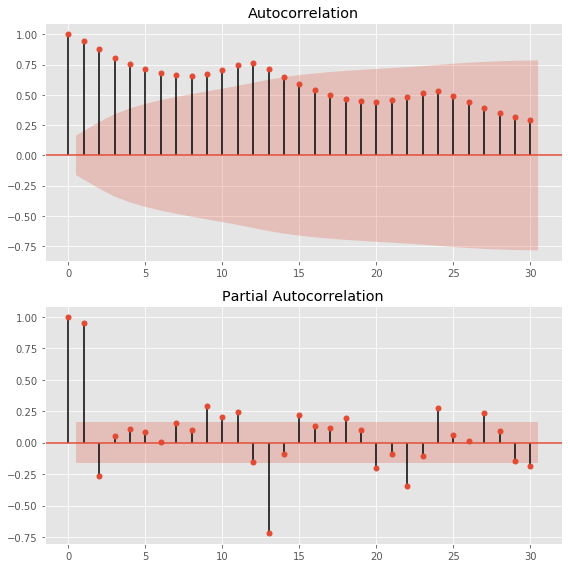

In [44]:
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(passengers, lags=30, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(passengers, lags=30, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

### 系列

- 原系列：なにも変換処理していない元データ
- 対数系列：原系列を対数変換したもの
- 階差系列：階差に変換した系列
- 季節調整済み系列：季節変動を取り除いた系列

#### 階差系列

In [39]:
passengers_diff = passengers - passengers.shift() # 階差系列データの作成

In [40]:
passengers_diff.head() # 階差系列(1次階差)

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: #Passengers, dtype: float64

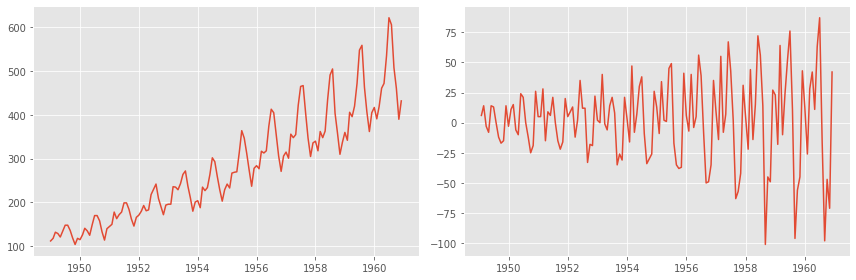

In [41]:
passengers_diff = passengers_diff.dropna() # Nanデータ削除

fig = plt.figure(figsize=(12, 4))

# 原型列のグラフ
ax1 = fig.add_subplot(121)
plt.plot(passengers)

# 階差系列のグラフ
ax2 = fig.add_subplot(122)
plt.plot(passengers_diff)

plt.tight_layout() # グラフ間スキマ調整

階差系列で、右肩上がりのトレンド成分が取り除かれた

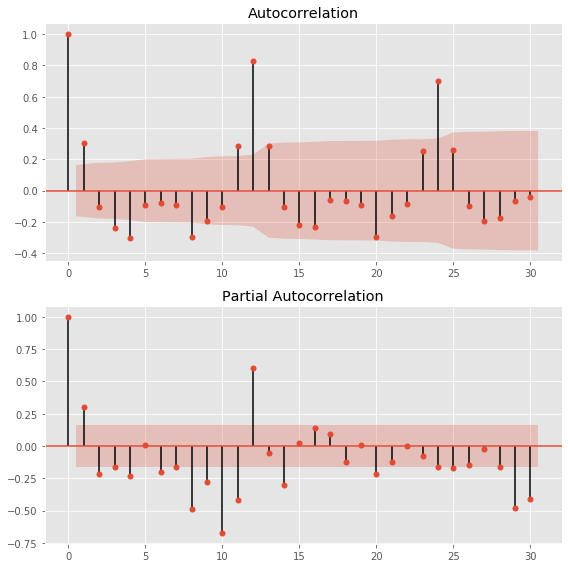

In [43]:
# 階差系列データでコレログラム作成
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(passengers_diff, lags=30, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(passengers_diff, lags=30, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

- ラグ12の箇所で強い自己相関→1年（12か月）周期での変動傾向
- スパイク：グラフで周辺と比べて突出したところ

#### 対数系列
- 変動の分散を一様化

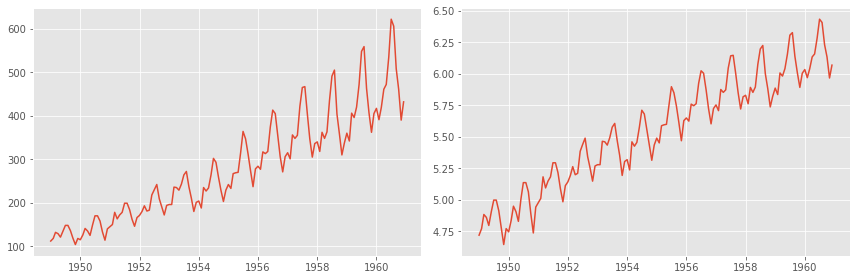

In [53]:
passengers_log = np.log(passengers)

fig = plt.figure(figsize=(12, 4))

# 原型列のグラフ
ax1 = fig.add_subplot(121)
plt.plot(passengers)

# 対数系列のグラフ
ax2 = fig.add_subplot(122)
plt.plot(passengers_log)

plt.tight_layout()

- 変動の振れ幅が一定になった

#### 季節調整済系列
原系列 = トレンド + 季節変動 + 残差

原系列 - トレンド - 季節変動 = 残差

→残差はトレンドと季節変動が取り除かれた定常性のある時系列データ

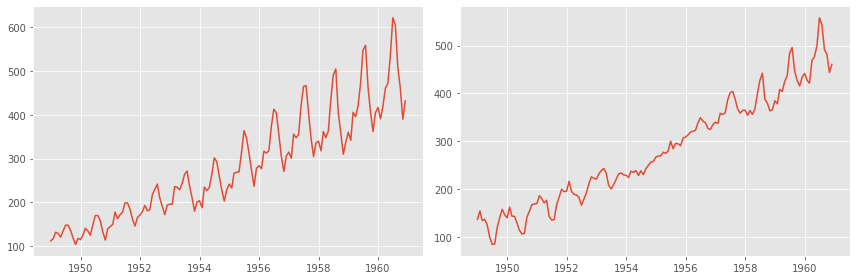

In [55]:
original = passengers #オリジナルデータ
trend = res.trend #トレンド
seasonal = res.seasonal #季節性
residual = res.resid #残差

passengers_del_seasonal = original - seasonal

fig = plt.figure(figsize=(12, 4))

# 原型列のグラフ
ax1 = fig.add_subplot(121)
plt.plot(passengers)

# 対数系列のグラフ
ax2 = fig.add_subplot(122)
plt.plot(passengers_del_seasonal)

plt.tight_layout()

In [ ]:
- 

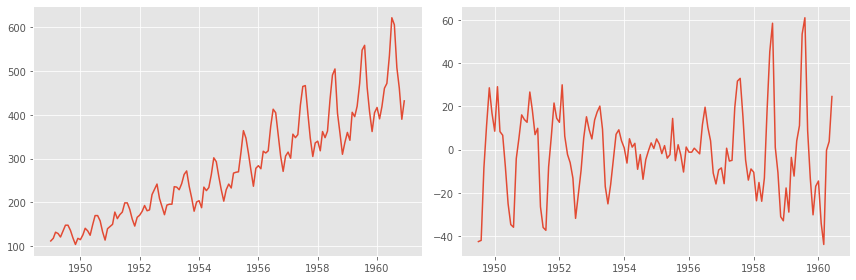

In [56]:
passengers_del_seasonal_trend = original - seasonal- trend

fig = plt.figure(figsize=(12, 4))

# 原型列のグラフ
ax1 = fig.add_subplot(121)
plt.plot(passengers)

# 対数系列のグラフ
ax2 = fig.add_subplot(122)
plt.plot(passengers_del_seasonal_trend)

plt.tight_layout()

### 定常過程・非定常過程

定常性：時間や位置によってその確率分布が変化しないという確率過程の性質

→時間の経過によらず一定の値を軸に同程度の幅で振れて変化する性質

- 弱定常性：時系列データの期待値と自己共分散が時間を通して一定であるという意味。自己共分散とは今の自分からt時（時間）離れた自分との間の共分散、両者の間にどれくらいのばらつきがあるか、のこと
    - 期待値が一定＝時間の経過によらず一定の値を軸に変動している
    - 自己共分散が一定＝データのばらつきが一定＝同程度の幅で振れて変化する

- 強定常性：時系列の文脈では扱わないm

#### ホワイトノイズ
https://aidemyexcontentspic.blob.core.windows.net/contents-pic/5060_tsa/02_02.jpg

- 弱定常性を持つ
- 時系列モデルにおける、不規則変動パターン（誤差）を担う
- 不規則変動自体は数学的な再現が難しいため、ホワイトノイズを用いる

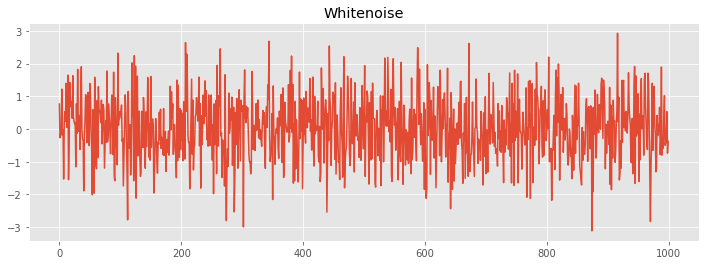

In [67]:
#ホワイトノイズの設定
mean = 0
std = 1 
num_samples = 1000
samples = np.random.normal(mean, std, size=num_samples)
# ホワイトノイズのプロット
fig = plt.figure(figsize=(12,4))
plt.title("Whitenoise")
plt.plot(samples)
plt.show()

#### 定常性はなぜ重要か

- 時系列データにおいては定常性がないデータを分析した結果全く意味のない相関(Aが上がればBも上がる、もしくは下がるという関係)を検出してしまう可能性があるため
- 時系列データとは時間の経過に沿って変化するデータのため、「時間の経過」という共通項目 が無意味な相関関係を産んでしまう。(疑似相関)

ex) 中国のGDPと、私の体重。20年間どちらも増え続けている→中国のGDPが伸びたのは私の体重が増えたからだ！　

これ疑似相関

#### 非定常過程を定常過程に変換するには？

- 対数変換
- 移動平均でトレンド推定→トレンド成分除去
- 階差系列（トレンド、季節変動除去）
- 季節調整

##### 移動平均（他3つは系列で解説済み）

移動平均とは時系列データのある一定の区間で”平均”をとる、ということを区間を”移動”させながら繰り返すこと

例えば月ごとのデータに季節変動がある場合、12個の連続する値の移動平均を求めることで、季節変動を除去することができトレンド成分を抽出することができる。

もとめた移動平均をもとの系列から引き算することで系列のトレンド成分を除去することができる。

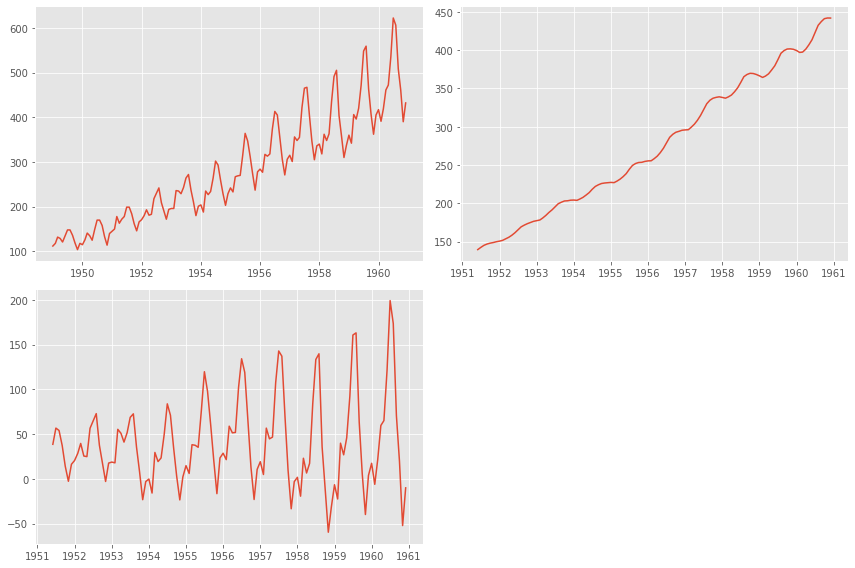

In [66]:
fig = plt.figure(figsize=(12,8))
# 原型列のグラフ
ax1 = fig.add_subplot(2,2,1)
plt.plot(passengers)

#移動平均をもとめる
passengers_ma = passengers.rolling(window=30).mean()

# 移動平均グラフ
ax2 = fig.add_subplot(2,2,2)
plt.plot(passengers_ma)

#原系列-移動平均グラフ
passengers_ma_del = passengers - passengers_ma

ax3 = fig.add_subplot(2,2,3)
plt.plot(passengers_ma_del)

plt.tight_layout()

#### 単位根過程

- 非定常だけど、差分をとると（弱）定常になるようなデータ

#### Augmented Dickey-Fuller test
- 『単位根過程である』を帰無仮説とした仮説検定
- 棄却されれば、データが定常過程であるとみなせる

In [69]:
#データ読み込み直し
df = pd.read_csv('data/AirPassengers.csv')
passengers = pd.Series(df['#Passengers'], dtype='float') 
passengers.index = pd.to_datetime(df['Month'])

In [70]:
# ADF検定（原型列で確認だけ）
res_ctt = sm.tsa.stattools.adfuller(passengers, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = sm.tsa.stattools.adfuller(passengers, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = sm.tsa.stattools.adfuller(passengers, regression="c") # トレンド項なし、定数項あり
res_nc = sm.tsa.stattools.adfuller(passengers, regression="nc") # トレンド項なし、定数項なし
print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-3.2336779226436367, 0.19594187397031387, 13, 130, {'1%': -4.462541514337733, '5%': -3.8786113536640876, '10%': -3.5817528944014563}, 988.8119525594963)
(-2.1007818138446632, 0.5456589343124588, 13, 130, {'1%': -4.030152423759672, '5%': -3.444817634956759, '10%': -3.1471816659080565}, 993.2814778200581)
(0.815368879206053, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
(2.3906017343512285, 0.9971802685434735, 13, 130, {'1%': -2.583153076923077, '5%': -1.9432510546199364, '10%': -1.614925969959035}, 997.0955704315447)


見方
- Test static 
- p_value
- #lags used
- Number of Observation Used
- Critical Value (1%)
- Critical Value (5%)
- Critical Value (10%)

Test staticがCritical Valueを下回っていたら〇％の信頼度をもって定常といえる。

参考：https://www.procrasist.com/entry/12-time-series

→　どの条件でもp-valueが高く帰無仮説を棄却できないから、定常とは言えない

In [72]:
#階差系列に変換してADF検定にかける
passengers_diff = passengers - passengers.shift()
res_diff = sm.tsa.stattools.adfuller(passengers_diff.fillna(0))

In [73]:
print(res_diff)

(-2.8891860694712554, 0.04662003920675459, 12, 131, {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}, 995.4013901509479)


→ギリ95%信頼区間内

## 統計モデル

- AR, MA, ARMA →　定常過程を前提とする
- ARIMA　→　非定常過程もOK。原系列のd階差をとってからARMAにかける。季節変動があると適用できない
- SARIMA　→　季節性のある時系列データも扱えるARIMAの発展形

### SARIMAモデルの実践

#### 改めてデータ読み込み

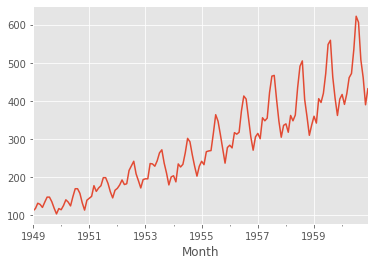

In [46]:
df = pd.read_csv('data/AirPassengers.csv')

passengers = pd.Series(df['#Passengers'], dtype='float') 
passengers.index = pd.to_datetime(df['Month']) 

passengers.plot()

SARIMA(p, d, q)(P, D, Q)[s]

- p,d,qは、ARIMAに適用するAR,差分,MAの次数
- P,D,Qは同じ対応順だけど、季節調整に適用する次数
- sは季節調整に適用する周期

#### パラメータはどうやって決める？

- ARの次数p、MAの次数qは自動推定みたいな機能があるが、確実ではない
- データをよく観察した上である程度当たりをつけて、最後は力技で組み合わせパターンの総当たりチェック。その中からベストな次数を選ぶとういう手法がよく使われている

"時系列データの内容にもよるけど、目安の次数範囲はあるみたい。ARMA(p,q)は0～3程度、差分は0か1（多くても2？）、P,Qはあまり大きな次数となるケースが少ないなども参考になるよ。"

##### 参考：Aidemyに乗ってたパラメータ探索関数
- 各パラメータにレンジを定め、BIC（情報量基準）が最も小さくなるパラメータを探索
- BICについて　https://ameblo.jp/yusaku-ohkubo/entry-12257909424.html

In [82]:
import itertools
def selectparameter(DATA,s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA,
                                            order=param,
                                            seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(BICs,results.bic)
            except:
                continue
    return parameters[np.argmin(BICs)]

##### ARMA(p,q)の次数の自動推定

- ARMAはトレンドある原系列には使えないので、階差をとってから

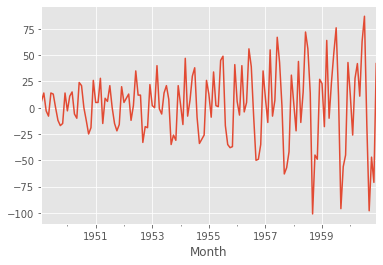

In [74]:
passengers_diff = passengers - passengers.shift() # 差分(1階差)　Pandasのdiff()でpassengers.diff()としてもOK
passengers_diff = passengers_diff.dropna() # 1個できるNaNデータは捨てる
passengers_diff.plot()

In [75]:
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(passengers_diff, ic='aic', trend='nc')
res_selection

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175660
 3  1395.021214  1379.614000  1351.138705
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

AICは値が小さいほど良い

AICを最も小さくしてくれるベストなp, qの組み合わせを探索してくれた

### SARIMAモデル作成

In [76]:
model = sm.tsa.SARIMAX(passengers, 
                        order=(3, 1, 2),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [77]:
sarimax_resid = model.resid # モデルの残差成分

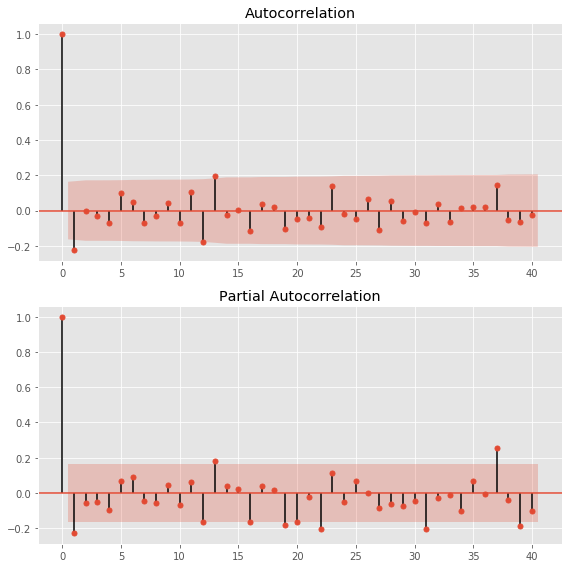

In [78]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

解釈の仕方
- 残差に周期性や自己相関がたくさん残ってるいると、予測モデルとしてはダメでモデルの再考が必要

#### SARIMAモデル季節調整なし

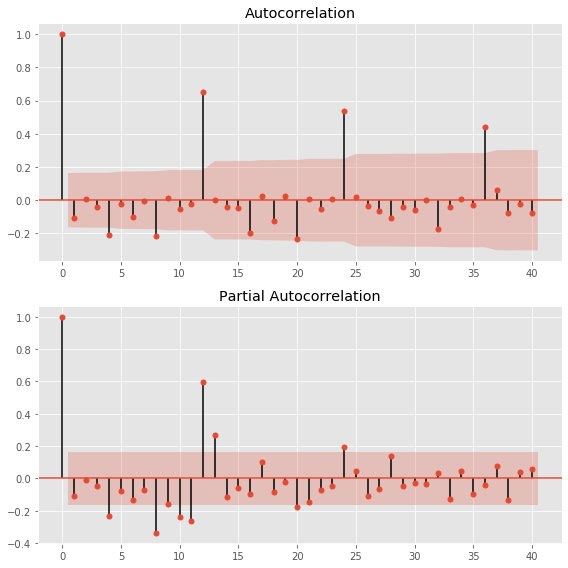

In [80]:
sarimax_noseasonal = sm.tsa.SARIMAX(passengers, 
                        order=(3, 1, 2),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_noseasonal_resid = sarimax_noseasonal.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_noseasonal_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_noseasonal_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

- 残差に周期性が残るため、NG

#### Selectparameters関数を使った場合

In [83]:
selectparameter(passengers, 12)

[(1, 1, 0), (0, 1, 0, 12), 1026.143833916827]

In [85]:
model2 = sm.tsa.SARIMAX(passengers, 
                        order=(1, 1, 0),
                        seasonal_order=(0, 1, 0, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [86]:
sarimax_resid2 = model2.resid # モデルの残差成分

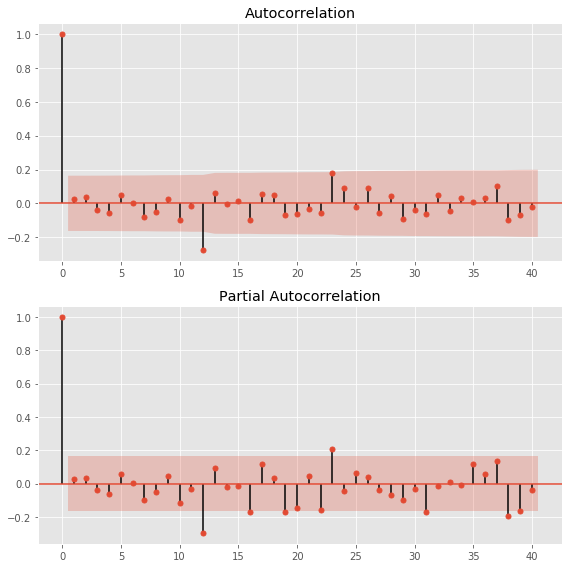

In [87]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid2, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid2, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -449.020
Date:                            Tue, 17 Dec 2019   AIC                            914.041
Time:                                    20:53:53   BIC                            936.070
Sample:                                01-01-1949   HQIC                           922.983
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0247      0.797      1.286      0.198      -0.537       2.587
ar.L2          0.0095      0.537      0.018      0.986      -1.043       1.062
ar.L3         -0.1785      0.145     -1.232      0.218      -0.462       0.105
ma.L1         -1.4109      0.806     -1.750      0.080      -2.991       0.169
ma.L2          0.4226      0.790      0.535      0.593      -1.126       1.971
ar.S.L12      -0.5304      0.352     -1.505      0.132      -1.221       0.160
ma.S.L12       0.4024      0.418      0.963      0.335      -0.416       1.221
sigma2       131.7179     17.959      7.334      0.000      96.519     166.917
===================================================================================
Ljung-Box (Q):                       49.49   Jarque-Bera (JB):                13.61
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -504.684
Date:                            Tue, 17 Dec 2019   AIC                           1013.368
Time:                                    20:54:06   BIC                           1019.103
Sample:                                01-01-1949   HQIC                          1015.698
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3096      0.074     -4.190      0.000      -0.454      -0.165
sigma2       137.8950     14.819      9.305      0.000     108.850     166.940
===================================================================================
Ljung-Box (Q):                       50.98   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.11   Prob(JB):                         0.03
Heteroskedasticity (H):               2.34   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- model2よりmodelのほうが良かった模様

#### よりよいパラメータを求めて。GridSearch

In [93]:
import warnings
warnings.filterwarnings('ignore') # 警告非表示（収束：ConvergenceWarning）

# パラメータ範囲
# order(p, d, q)
min_p = 1; max_p = 3 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 1
min_sd = 0; max_sd = 1
min_sq = 0; max_sq = 1

test_pattern = (max_p - min_p +1)*(max_q - min_q + 1)*(max_d - min_d + 1)*(max_sp - min_sp + 1)*(max_sq - min_sq + 1)*(max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 12 # seasonal_order周期パラメータ
ts = passengers # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p, d, q), 
                            seasonal_order=(sp, sd, sq, sfq), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        print(num,'/', test_pattern-1, test_results.iloc[num]["model_parameters"],  test_results.iloc[num]["aic"] )
                        num = num + 1

# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])

pattern: 192
0 / 191 order=(1,0,0), seasonal_order=(0,0,0) 1415.9068815931882
1 / 191 order=(1,0,0), seasonal_order=(0,0,1) 1205.3907786172606
2 / 191 order=(1,0,0), seasonal_order=(0,1,0) 1029.977309170107
3 / 191 order=(1,0,0), seasonal_order=(0,1,1) 944.3854921533207
4 / 191 order=(1,0,0), seasonal_order=(1,0,0) 1017.3155493564152
5 / 191 order=(1,0,0), seasonal_order=(1,0,1) 1007.0272557322276
6 / 191 order=(1,0,0), seasonal_order=(1,1,0) 944.0441660823202
7 / 191 order=(1,0,0), seasonal_order=(1,1,1) 945.4400866754598
8 / 191 order=(1,0,1), seasonal_order=(0,0,0) 1390.4515018414922
9 / 191 order=(1,0,1), seasonal_order=(0,0,1) 1192.2949631619488
10 / 191 order=(1,0,1), seasonal_order=(0,1,0) 1014.2547824625115
11 / 191 order=(1,0,1), seasonal_order=(0,1,1) 929.4329707892193
12 / 191 order=(1,0,1), seasonal_order=(1,0,0) 1009.5891017292032
13 / 191 order=(1,0,1), seasonal_order=(1,0,1) 989.1764737726387
14 / 191 order=(1,0,1), seasonal_order=(1,1,0) 935.8163348218255
15 / 191 order

125 / 191 order=(2,1,3), seasonal_order=(1,0,1) 978.1618816793097
126 / 191 order=(2,1,3), seasonal_order=(1,1,0) 920.9443971629032
127 / 191 order=(2,1,3), seasonal_order=(1,1,1) 906.0326961890124
128 / 191 order=(3,0,0), seasonal_order=(0,0,0) 1380.7458703932875
129 / 191 order=(3,0,0), seasonal_order=(0,0,1) 1201.625766530031
130 / 191 order=(3,0,0), seasonal_order=(0,1,0) 1008.7465064755769
131 / 191 order=(3,0,0), seasonal_order=(0,1,1) 937.5672738392819
132 / 191 order=(3,0,0), seasonal_order=(1,0,0) 996.6216552977387
133 / 191 order=(3,0,0), seasonal_order=(1,0,1) 983.9064043738372
134 / 191 order=(3,0,0), seasonal_order=(1,1,0) 922.4280801306516
135 / 191 order=(3,0,0), seasonal_order=(1,1,1) 928.9789439420155
136 / 191 order=(3,0,1), seasonal_order=(0,0,0) 1381.0403561243527
137 / 191 order=(3,0,1), seasonal_order=(0,0,1) 1166.6356614956194
138 / 191 order=(3,0,1), seasonal_order=(0,1,0) 1010.7204332738633
139 / 191 order=(3,0,1), seasonal_order=(0,1,1) 932.6552398279878
140 /

In [95]:
model3 = sm.tsa.SARIMAX(passengers, 
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [97]:
sarimax_resid3 = model3.resid # モデルの残差成分

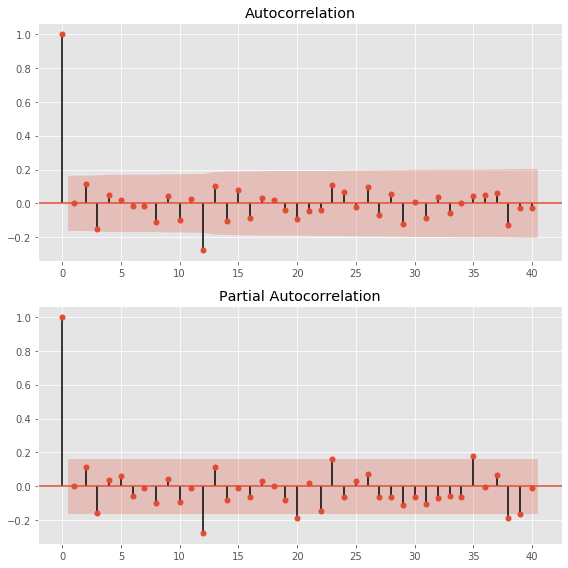

In [98]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid3, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid3, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [99]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -441.052
Date:                            Tue, 17 Dec 2019   AIC                            898.105
Time:                                    21:00:09   BIC                            920.064
Sample:                                01-01-1949   HQIC                           907.018
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2231      0.097     -2.302      0.021      -0.413      -0.033
ar.L2         -0.1642      0.108     -1.515      0.130      -0.377       0.048
ar.L3          0.7244      0.094      7.704      0.000       0.540       0.909
ma.L1         -0.0837    116.977     -0.001      0.999    -229.354     229.186
ma.L2          0.1221    146.479      0.001      0.999    -286.971     287.215
ma.L3         -0.9797    255.802     -0.004      0.997    -502.342     500.383
ma.S.L12      -0.1583      0.118     -1.337      0.181      -0.390       0.074
sigma2       119.6719   3.12e+04      0.004      0.997   -6.11e+04    6.14e+04
===================================================================================
Ljung-Box (Q):                       36.68   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.62   Prob(JB):                         0.11
Heteroskedasticity (H):               1.87   Skew:                             0.16
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 予測

- predictで予測

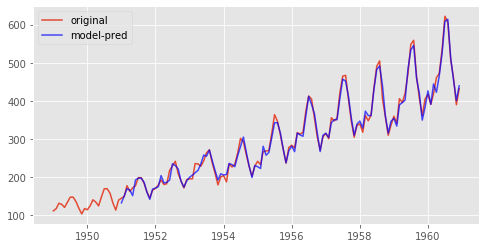

In [100]:
sarimax_pred = model3.predict('1951-01', '1960-12') 

plt.figure(figsize=(8, 4))

plt.plot(passengers, label="original")
plt.plot(sarimax_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

- オリジナルデータにない未来時点の予測

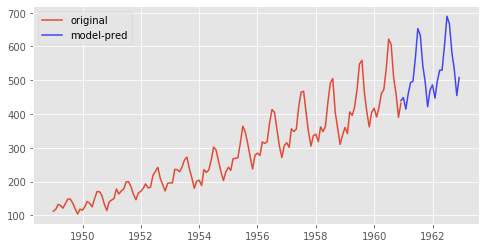

In [101]:
sarimax_pred = model3.predict('1960-12', '1962-12') 

plt.figure(figsize=(8, 4))

plt.plot(passengers, label="original")
plt.plot(sarimax_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

### testデータを作成して検証

In [102]:
# オリジナル passengers 1949-01 ～ 1960-12
passengers_train = passengers['1949-01':'1958-12'] # モデル作成用データ（訓練）

In [103]:
passengers_test = passengers['1958-01':'1960-12'] # テスト用データ2年分

In [104]:
#SARIMAモデル
sarimax_train = sm.tsa.SARIMAX(passengers_train, 
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [107]:
#予測
sarimax_train_pred = sarimax_train.predict('1958-12', '1960-12') # テストデータ2年分予測

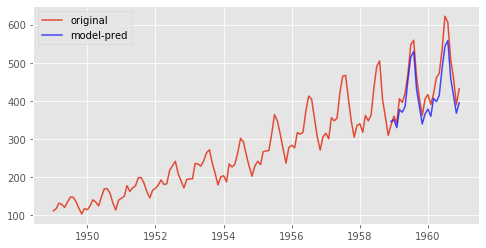

In [108]:
plt.figure(figsize=(8, 4))

plt.plot(passengers, label="original")
plt.plot(sarimax_train_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

### 予測誤差

In [109]:
predict_dy = sarimax_train.get_prediction(start ='1958-12', end='1960-12')
type(predict_dy)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [110]:
predict_dy_ci = predict_dy.conf_int(alpha=0.05) # defalut alpah=0.05 :returns a 95% confidence interval
type(predict_dy_ci)

pandas.core.frame.DataFrame

In [113]:
#予測誤差の上限下限
print(predict_dy_ci)

            lower #Passengers  upper #Passengers
1958-12-01         327.130180         365.373321
1959-01-01         331.688173         369.929935
1959-02-01         305.775935         354.388209
1959-03-01         348.852812         405.782253
1959-04-01         340.108028         400.850685
1959-05-01         354.547400         416.852307
1959-06-01         424.247036         488.398612
1959-07-01         482.288962         547.730557
1959-08-01         496.852410         562.656863
1959-09-01         397.347364         463.561867
1959-10-01         352.527942         419.263585
1959-11-01         306.366652         373.238984
1959-12-01         332.538712         399.486275
1960-01-01         339.645493         417.888879
1960-02-01         317.798914         402.023422
1960-03-01         362.188102         451.225152
1960-04-01         352.356006         444.256012
1960-05-01         367.946420         461.227591
1960-06-01         438.532143         533.060189
1960-07-01         4

In [114]:
#予測の平均値
predict_dy.predicted_mean 

1958-12-01    346.251751
1959-01-01    350.809054
1959-02-01    330.082072
1959-03-01    377.317533
1959-04-01    370.479357
1959-05-01    385.699853
1959-06-01    456.322824
1959-07-01    515.009760
1959-08-01    529.754637
1959-09-01    430.454616
1959-10-01    385.895763
1959-11-01    339.802818
1959-12-01    366.012494
1960-01-01    378.767186
1960-02-01    359.911168
1960-03-01    406.706627
1960-04-01    398.306009
1960-05-01    414.587006
1960-06-01    485.796166
1960-07-01    543.149342
1960-08-01    558.052736
1960-09-01    459.719983
1960-10-01    414.433636
1960-11-01    367.885285
1960-12-01    394.927745
Freq: MS, dtype: float64

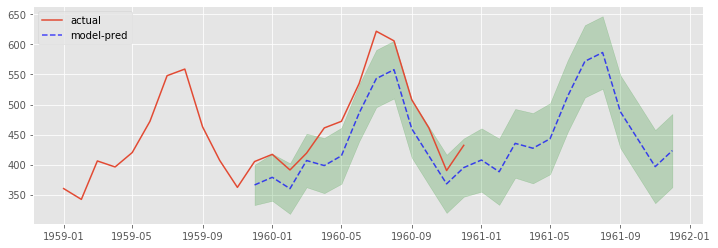

In [118]:
predict2_dy = sarimax_train.get_prediction(start ='1959-12', end='1961-12') # 2年分の未来予測

predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(passengers['1959-01':], label="actual")
plt.plot(predict2_dy.predicted_mean, c="b", linestyle='--', label="model-pred", alpha=0.7)

plt.fill_between(predict2_dy_ci.index, predict2_dy_ci.iloc[:, 0], predict2_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')